In [1]:
import os,sys,glob
from matplotlib import colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
from itertools import combinations
from sklearn.metrics import mean_squared_error
from scipy import stats

In [43]:
### subjects
def collectSubjectData(topPath,dataPath,groups,subjects,colors):

    # set up variables
    data_columns = ['subjectID','classID','colors']
    data =  pd.DataFrame([],columns=data_columns)

    # populate structure
    data['subjectID'] = [ f for g in groups for f in subjects[g] ]
    data['classID'] = [ g for g in groups for f in range(len(subjects[g]))]
    data['colors'] = [ colors[c] for c in colors for f in subjects[c]]

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'subjects.csv',index=False)

    return data

### color dictionary
def createColorDictionary(data,measure,colorPalette):

    keys = data[measure].unique()
    values = sns.color_palette(colorPalette,len(keys))
    values = values.as_hex()

    colors_dict = dict(zip(keys,values))

    return colors_dict

### load parcellation stats data 
### load data 
def collectData(datatype,datatype_tags,tags,filename,subjects_data,colors,outPath):

    import requests
    import pandas as pd

    # grab path and data objects
    objects = requests.get('https://brainlife.io/api/warehouse/secondary/list/%s'%os.environ['PROJECT_ID']).json()
    
    # subjects and paths
    subjects = []
    paths = []
    
    # set up output
    data = pd.DataFrame()

    # loop through objects
    for obj in objects:
        if obj['datatype']['name'] == datatype:
            if datatype_tags in obj['output']['datatype_tags']:
                if tags in obj['output']['tags']:
                    subjects = np.append(subjects,obj['output']['meta']['subject'])
                    paths = np.append(paths,"input/"+obj["path"]+"/"+filename)
    
    # sort paths by subject order
    paths = [x for _,x in sorted(zip(subjects,paths))]

    for i in paths:
        tmpdata = pd.read_csv(i)
        if tmpdata.subjectID.dtypes != 'object':
            tmpdata['subjectID'] = [ str(int(np.float(f))) for f in tmpdata.subjectID ]
        if 'classID' in tmpdata.keys():
            tmpdata = pd.merge(tmpdata,subjects_data,on=['subjectID','classID'])
        else:
            tmpdata = pd.merge(tmpdata,subjects_data,on='subjectID')
        data = data.append(tmpdata,ignore_index=True)
            
    # replace empty spaces with nans
    data = data.replace(r'^\s+$', np.nan, regex=True)

    # output data structure for records and any further analyses
    # subjects.csv
    data.to_csv(outPath,index=False)

    return data

### cut nodes
def cutNodes(data,num_nodes,dataPath,foldername,savename):

    # identify inner n nodes based on num_nodes input
    total_nodes = len(data['nodeID'].unique())
    cut_nodes = int((total_nodes - num_nodes) / 2)

    # remove cut_nodes from dataframe
    data = data[data['nodeID'].between((cut_nodes)+1,(num_nodes+cut_nodes))]

    # replace empty spaces with nans
    data = data.replace(r'^\s+$', np.nan, regex=True)

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'/'+foldername+'-'+savename+'.csv',index=False)

    return data

def computeMeanData(dataPath,data,outname):

    # make mean data frame
    data_mean =  data.groupby(['subjectID','classID','structureID']).mean().reset_index()
    data_mean['nodeID'] = [ 1 for f in range(len(data_mean['nodeID'])) ]

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data_mean.to_csv(dataPath+outname+'.csv',index=False)

    return data_mean

### rank order effect size calculator
def computeRankOrderEffectSize(groups,subjects,tissue,measures,stat,measures_to_average,data_dir):

    comparison_array = list(combinations(groups,2)) # 2 x 2 array; 2 different comparisons, with two pairs per comparison. comparison_array[0] = ("run_1","run_2")
    es = {}
    roes = {}

    # compute effect size
    for compar in comparison_array:
        es[compar[0]+"_"+compar[1]] = pd.DataFrame([])
        tmp = pd.DataFrame([])
        tmp['structureID'] = stat['structureID'].unique()
        for m in measures:
            diff = stat[['structureID',m]][stat['classID'].str.contains(compar[0])].groupby('structureID').mean() - stat[['structureID',m]][stat['classID'].str.contains(compar[1])].groupby('structureID').mean()
            pooled_var = (np.sqrt((stat[['structureID',m]][stat['classID'].str.contains(compar[0])].groupby('structureID').std() ** 2 + stat[['structureID',m]][stat['classID'].str.contains(compar[1])].groupby('structureID').std() ** 2) / 2))
            effectSize = diff / pooled_var
            tmp[m+"_effect_size"] = list(effectSize[m])
        tmp.to_csv(data_dir+tissue+"_effect_sizes_"+compar[0]+"_"+compar[1]+".csv",index=False)
        es[compar[0]+"_"+compar[1]] = pd.concat([es[compar[0]+"_"+compar[1]],tmp],ignore_index=True)

    # rank order structures
    for ma in measures_to_average:
        if ma == ['ad','fa','md','rd','ga','ak','mk','rk']:
            model = 'tensor'
        elif ma == ['ndi','isovf','odi']:
            model = 'noddi'
        else:
            model = ma

        tmpdata = pd.DataFrame([])
        tmpdata['structureID'] = stat['structureID'].unique()
        for compar in comparison_array:
            if model == 'tensor':
                tmpdata[compar[0]+"_"+compar[1]+"_"+model+"_average_effect_size"] = es[compar[0]+"_"+compar[1]][['ad_effect_size','fa_effect_size','md_effect_size','rd_effect_size']].abs().mean(axis=1).tolist()
            elif model == 'noddi':
                tmpdata[compar[0]+"_"+compar[1]+"_"+model+"_average_effect_size"] = es[compar[0]+"_"+compar[1]][['ndi_effect_size','isovf_effect_size','odi_effect_size']].abs().mean(axis=1).tolist()
            else:
                tmpdata[compar[0]+"_"+compar[1]+"_"+model+"_average_effect_size"] = es[compar[0]+"_"+compar[1]][[ma+'_effect_size']].abs().mean(axis=1).tolist()

        tmpdata[model+"_average_effect_size"] =  tmpdata.mean(axis=1).tolist()
        tmpdata.to_csv(data_dir+model+"_average_"+tissue+"_effect_sizes.csv",index=False)
        roes[model] = tmpdata.sort_values(by=model+"_average_effect_size")['structureID'].tolist()

    return roes

def combineCorticalSubcortical(dataPath,corticalData,subcorticalData):

    # remove unnecessary columns
    corticalData = corticalData.drop(columns=['snr','thickness'])
    subcorticalData = subcorticalData.drop(columns=['parcID','number_of_voxels'])

    # merge data frames
    data = pd.concat([corticalData,subcorticalData],sort=False)

    # output data structure for records and any further analyses
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    data.to_csv(dataPath+'graymatter_nodes.csv',index=False)

    # identify gray matter names
    graymatter_names = list(data['structureID'].unique())

    # output track names
    if not os.path.exists(dataPath):
        os.mkdir(dataPath)

    with open((dataPath+'graymatter_list.json'),'w') as gm_listf:
        json.dump(graymatter_names,gm_listf)

    return [graymatter_names,data]

# # def computeDistance(x,y,metric):

# #     from sklearn.metrics.pairwise import euclidean_distances
# #     from scipy.stats import wasserstein_distance

# #     if metric == 'euclidean':
# #         dist = euclidean_distances([x,y])[0][1]
# #     else:
# #         dist = wasserstein_distance(x,y)
        
# #     return dist

# def computeDistance(x,y,metric):

#     from sklearn.metrics.pairwise import euclidean_distances
#     from scipy.stats import wasserstein_distance

#     if metric == 'euclidean':
#         dist = euclidean_distances([x,y])[0][1]
#     else:
#         dist = [ wasserstein_distance([x],[y[0]]) for x in x ]
        
#     return dist


# def computeReferences(x,groupby_measures,index_measure,diff_measures):
    
#     references_mean = x.groupby(groupby_measures).mean().reset_index(index_measure)
#     references_sd = x.groupby(groupby_measures).std().reset_index(index_measure)
#     references_sd[diff_measures] = references_sd[diff_measures] * 2
    
#     return references_mean, references_sd

# # def createDistanceDataframe(data,structures,groupby_measure,measures,dist_metric):
    
# #     dist = []
# #     subj = []
# #     meas = []
# #     struc = []

# #     for i in structures:
# #         print(i)
# #         subj_data = data.loc[data['structureID'] == i]
# #         references_data = computeReferences(subj_data,groupby_measure,groupby_measure,measures)
# #         for m in measures:
# #             for s in subj_data.subjectID.unique():
# #                 x = list(subj_data.loc[subj_data['subjectID'] == s][m].values.tolist())
# #                 y = list(references_data[0][m].values.tolist())
# #                 dist = np.append(dist,computeDistance(x,y,dist_metric))
# #                 subj = np.append(subj,s)
# #                 meas = np.append(meas,m)
# #                 struc = np.append(struc,i)

# #     dist_dataframe = pd.DataFrame()
# #     dist_dataframe['subjectID'] = subj
# #     dist_dataframe['structureID'] = struc
# #     dist_dataframe['measures'] = meas
# #     dist_dataframe['distance'] = dist
    
# #     return dist_dataframe

# def createDistanceDataframe(data,structures,groupby_measure,measures,dist_metric):
    
#     dist = []
#     subj = []
#     meas = []
#     struc = []

#     for i in structures:
#         print(i)
#         subj_data = data.loc[data['structureID'] == i]
#         references_data = computeReferences(subj_data,groupby_measure,groupby_measure,measures)
#         for m in measures:
#             dist = np.append(dist,computeDistance(subj_data[m].values,references_data[0][m].values,'emd'))
#             subj = np.append(subj,subj_data.subjectID.unique().tolist())
#             meas = np.append(meas,[ m for f in range(len(subj_data[m])) ])
#             struc = np.append(struc,[ i for f in range(len(subj_data[m])) ])

#     dist_dataframe = pd.DataFrame()
#     dist_dataframe['subjectID'] = subj
#     dist_dataframe['structureID'] = struc
#     dist_dataframe['measures'] = meas
#     dist_dataframe['distance'] = dist
    
#     return dist_dataframe

# def outputReferenceJson(ref_data,measures,data_dir,filename):
    
#     reference_json = []
#     for st in ref_data.structureID.unique():
#         i=0
#         tmp = {}
#         tmp['structurename'] = st
#         tmp['source'] = "HCP"
#         for meas in measures:
#             tmp[meas] = {}
#             tmp[meas]['mean'] = ref_data.loc[ref_data['structureID'] == st][meas].dropna().mean()
#             tmp[meas]['min'] = ref_data.loc[ref_data['structureID'] == st][meas].dropna().min()
#             tmp[meas]['max'] = ref_data.loc[ref_data['structureID'] == st][meas].dropna().max()
#             tmp[meas]['sd'] = ref_data.loc[ref_data['structureID'] == st][meas].dropna().std()
#         reference_json.append(tmp)

#     with open(data_dir+'/'+filename,'w') as ref_out_f:
#         json.dump(reference_json,ref_out_f)
    
#     return reference_json

# def buildReferenceData(data,outliers,profile,data_dir,filename):
    
#     reference_data = pd.DataFrame()
    
#     for s in outliers.structureID.unique():
#         for m in outliers.measures.unique():
#             if profile:
#                 tmpdata = data.loc[data['structureID'] == s].loc[~data['subjectID'].isin(outliers.loc[outliers['structureID'] == s].loc[outliers['measures'] == m].subjectID.unique())][['structureID','subjectID','nodeID',m]].reset_index(drop=True)
#             else:
#                 tmpdata = data.loc[data['structureID'] == s].loc[~data['subjectID'].isin(outliers.loc[outliers['structureID'] == s].loc[outliers['measures'] == m].subjectID.unique())][['structureID','subjectID',m]].reset_index(drop=True)
#             reference_data = pd.concat([reference_data,tmpdata])
#     if not profile:
#         reference_data = reference_data.groupby(['structureID','subjectID']).mean().reset_index()
    
#     reference_data.to_csv(data_dir+'/'+filename+'.csv',index=False)
    
#     return reference_data

# def computeOutliers(distances,threshold):
    
#     outliers = pd.DataFrame()
    
#     for i in distances.structureID.unique():
#         for m in distances.measures.unique():
#             tmpdata = distances.loc[distances['structureID'] == i].loc[distances['measures'] == m]
#             outliers = pd.concat([outliers,tmpdata[tmpdata['distance'] > np.percentile(tmpdata['distance'],threshold)]])
            
#     return outliers

# def outlierDetection(data,structures,groupby_measure,measures,threshold,dist_metric,build_outliers,data_dir,filename):
    
#     import numpy as np, pandas as pd

#     outliers_subjects = []
#     outliers_structures = []
#     outliers_measures = []
#     outliers_metrics = []

#     distances = createDistanceDataframe(data,structures,groupby_measure,measures,dist_metric)
#     outliers_dataframe = computeOutliers(distances,threshold)
    
#     if build_outliers:
#         if 'neID' in data.columns:
#             reference_dataframe = buildReferenceData(data,outliers_dataframe,True)
#             reference_json = []
#         else:
#             reference_dataframe = buildReferenceData(data,outliers_dataframe,False)
#             reference_json = outputReferenceJson(reference_dataframe,measures,data_dir,filename)
#     else:
#         reference_dataframe = []
#         reference_json = []
        
#     return distances, outliers_dataframe, reference_dataframe, reference_json

def computeDistance(data,references_data,measures,metric):

    from sklearn.metrics.pairwise import euclidean_distances
    from scipy.stats import wasserstein_distance

    if metric == 'euclidean':
        dist = data.groupby('subjectID',sort=False).apply(lambda x: euclidean_distances([x[measures].values.tolist(),references_data[measures].values.tolist()])[0][1]).values
    else:
        dist = data.groupby('subjectID',sort=False).apply(lambda x: wasserstein_distance(x[measures],[references_data[measures].values[0]]))

    return dist

def computeReferences(x,groupby_measures,index_measure,diff_measures):
    
    references_mean = x.groupby(groupby_measures).mean().reset_index(index_measure)
    references_sd = x.groupby(groupby_measures).std().reset_index(index_measure)
    references_sd[diff_measures] = references_sd[diff_measures] * 2
    
    return references_mean, references_sd

def createDistanceDataframe(data,structures,groupby_measure,measures,dist_metric):
    
    from scipy.stats import wasserstein_distance

    dist = []
    subj = []
    meas = []
    struc = []

    for i in structures:
        print(i)
        subj_data = data.loc[data['structureID'] == i]
        references_data = computeReferences(subj_data,groupby_measure,groupby_measure,measures)
        for m in measures:
            if dist_metric == 'euclidean':
                dist = np.append(dist,computeDistance(subj_data,references_data[0],m,'euclidean'))
            else:
                dist = np.append(dist,computeDistance(subj_data,references_data[0],m,'emd'))
            
            subj = np.append(subj,subj_data.subjectID.unique().tolist())
            meas = np.append(meas,[ m for f in range(len(subj_data.subjectID.unique().tolist())) ])
            struc = np.append(struc,[ i for f in range(len(subj_data.subjectID.unique().tolist())) ])

    dist_dataframe = pd.DataFrame()
    dist_dataframe['subjectID'] = subj
    dist_dataframe['structureID'] = struc
    dist_dataframe['measures'] = meas
    dist_dataframe['distance'] = dist
    
    return dist_dataframe

# def outputReferenceJson(ref_data,measures,profile,resample_points,data_dir,filename):
    
#     import json
#     from scipy.signal import resample

#     reference_json = []
#     for st in ref_data.structureID.unique():
#         tmp = {}
#         tmp['structurename'] = st
#         tmp['source'] = "ping-siemens"
#         for meas in measures:
#             tmp[meas] = {}
#             if profile:
#                 gb_frame = ref_data.loc[ref_data['structureID'] == st][['nodeID',meas]].dropna().groupby('nodeID')[meas]
#             else:
#                 gb_frame = ref_data.loc[ref_data['structureID'] == st][[meas]].dropna()[meas]
            
#             if resample_points:
#                 mean_tmp = resample(gb_frame.mean().values.tolist(),resample_points).tolist()
#                 min_tmp = resample(gb_frame.min().values.tolist(),resample_points).tolist()
#                 max_tmp = resample(gb_frame.max().values.tolist(),resample_points).tolist()
#                 sd_tmp = resample(gb_frame.std().values.tolist(),resample_points).tolist()
#             else:
#                 mean_tmp = gb_frame.mean()
#                 min_tmp = gb_frame.min()
#                 max_tmp = gb_frame.max()
#                 sd_tmp = gb_frame.std()

#             tmp[meas]['mean'] = mean_tmp
#             tmp[meas]['min'] = min_tmp
#             tmp[meas]['max'] = max_tmp
#             tmp[meas]['sd'] = sd_tmp
#         reference_json.append(tmp)

#     with open(data_dir+'/'+filename+'.json','w') as ref_out_f:
#         json.dump(reference_json,ref_out_f)
    
#     return reference_json

def outputReferenceJson(ref_data,measures,profile,resample_points,data_dir,filename):
    
    import json
    from scipy.signal import resample

    for st in ref_data.structureID.unique():
        reference_json = []
        tmp = {}
        tmp['structurename'] = st
        tmp['source'] = "ping-siemens"
        for meas in measures:
            tmp[meas] = {}
            if profile:
                gb_frame = ref_data.loc[ref_data['structureID'] == st][['nodeID',meas]].dropna().groupby('nodeID')[meas]
            else:
                gb_frame = ref_data.loc[ref_data['structureID'] == st][[meas]].dropna()[meas]
            
            data_tmp = []
            if resample_points:                
                mean_tmp = resample(gb_frame.mean().values.tolist(),resample_points).tolist()
                min_tmp = resample(gb_frame.min().values.tolist(),resample_points).tolist()
                max_tmp = resample(gb_frame.max().values.tolist(),resample_points).tolist()
                sd_tmp = resample(gb_frame.std().values.tolist(),resample_points).tolist()
                five_tmp = resample(gb_frame.quantile(q=.05).values.tolist(),resample_points).tolist()
                twofive_tmp = resample(gb_frame.quantile(q=.25).values.tolist(),resample_points).tolist()
                sevenfive_tmp = resample(gb_frame.quantile(q=.75).values.tolist(),resample_points).tolist()
                ninefive_tmp = resample(gb_frame.quantile(q=.95).values.tolist(),resample_points).tolist()
                tmp[meas]['mean'] = mean_tmp
                tmp[meas]['min'] = min_tmp
                tmp[meas]['max'] = max_tmp
                tmp[meas]['sd'] = sd_tmp
                tmp[meas]['5_percentile'] = five_tmp
                tmp[meas]['25_percentile'] = twofive_tmp
                tmp[meas]['75_percentile'] = sevenfive_tmp
                tmp[meas]['95_percentile'] = ninefive_tmp
            else:
                data_tmp = gb_frame.values.tolist()
                tmp[meas]['data'] = data_tmp
        reference_json.append(tmp)

        with open(data_dir+'/'+filename+'_'+st+'.json','w') as ref_out_f:
            json.dump(reference_json,ref_out_f)
    
    return reference_json

def buildReferenceData(data,outliers,profile,data_dir,filename):
    
    reference_data = pd.DataFrame()
    
    for s in outliers.structureID.unique():
        for m in outliers.measures.unique():
            if profile:
                tmpdata = data.loc[data['structureID'] == s].loc[~data['subjectID'].isin(outliers.loc[outliers['structureID'] == s].loc[outliers['measures'] == m].subjectID.unique())][['structureID','subjectID','nodeID',m]].reset_index()
            else:
                tmpdata = data.loc[data['structureID'] == s].loc[~data['subjectID'].isin(outliers.loc[outliers['structureID'] == s].loc[outliers['measures'] == m].subjectID.unique())][['structureID','subjectID',m]].reset_index()
            reference_data = pd.concat([reference_data,tmpdata])
    if not profile:
        reference_data = reference_data.groupby(['structureID','subjectID']).mean().reset_index()
    
    reference_data.to_csv(data_dir+'/'+filename+'.csv',index=False)
    
    return reference_data

def computeOutliers(distances,threshold):
    
    outliers = pd.DataFrame()
    
    for i in distances.structureID.unique():
        for m in distances.measures.unique():
            tmpdata = distances.loc[distances['structureID'] == i].loc[distances['measures'] == m]
            outliers = pd.concat([outliers,tmpdata[tmpdata['distance'] > np.percentile(tmpdata['distance'],threshold)]])
            
    return outliers

def outlierDetection(data,structures,groupby_measure,measures,threshold,dist_metric,build_outliers,profile,resample_points,data_dir,filename):
    
    import numpy as np, pandas as pd

    outliers_subjects = []
    outliers_structures = []
    outliers_measures = []
    outliers_metrics = []

    distances = createDistanceDataframe(data,structures,groupby_measure,measures,dist_metric)
    outliers_dataframe = computeOutliers(distances,threshold)
    
    if build_outliers:
        reference_dataframe = buildReferenceData(data,outliers_dataframe,profile,data_dir,filename)
        reference_json = outputReferenceJson(reference_dataframe,measures,profile,resample_points,data_dir,filename)
    else:
        reference_dataframe = []
        reference_json = []
        
    return distances, outliers_dataframe, reference_dataframe, reference_json


def profileFlipCheck(data,subjects,structures,test_measure,flip_measures,dist_metric,threshold,outPath):
    
    flipped_subjects = []
    flipped_structures = []
    distance = []
    flipped_distance = []
    
    for i in structures:
        print(i)
        struc_data = data.loc[data['structureID'] == i]
        references_data = computeReferences(struc_data,'nodeID','nodeID',flip_measures)
        differences = []
        dist = []
        dist_flipped = []

        for s in subjects:
            subj_data = struc_data.loc[data['subjectID'] == s]
            x = list(subj_data[test_measure].values.tolist())
            y = list(references_data[0][test_measure].values.tolist())
            dist = np.append(dist,computeDistance(x,y,dist_metric))
            dist_flipped = np.append(dist_flipped,computeDistance(list(np.flip(x)),y,dist_metric))
            differences =  np.append(differences,(dist[-1]-dist_flipped[-1]))
        
        percentile_threshold = np.percentile(differences,threshold)
#         print(percentile_threshold)
        for m in range(len(differences)):
            if differences[m] > 0 and differences[m] > percentile_threshold:
#             if differences[m] > percentile_threshold:
#                 print(subjects[m])
                flipped_subjects = np.append(flipped_subjects,subjects[m])
                flipped_structures = np.append(flipped_structures,i)
                distance = np.append(distance,dist[m])
                flipped_distance = np.append(flipped_distance,dist_flipped[m])
    
    output_summary = pd.DataFrame()
    output_summary['flipped_subjects'] = flipped_subjects
    output_summary['flipped_structures'] = flipped_structures
    output_summary['distance'] = distance
    output_summary['flipped_distance'] = flipped_distance
    
    if outPath:
        output_summary.to_csv(outPath+'_flipped_profiles.csv',index=False)
    
    return output_summary

### scatter plot related scripts
# groups data by input measure and computes mean for each value in that column. x_stat is a pd dataframe, with each row being a single value, and each column being a different ID value or measure
def averageWithinColumn(x_stat,y_stat,x_measure,y_measure,measure):

    X = x_stat.groupby(measure).mean()[x_measure].tolist()
    Y = y_stat.groupby(measure).mean()[y_measure].tolist()

    return X,Y

# groups data by input measure and creates an array by appending data into x and y arrays. x_stat and y_stat are pd dataframes, with each row being a single value, and each column being a different ID value or measure
# designed for test retest. x_stat and y_stat should have the same number of rows. but more importantly, should correspond to the same source (i.e. subject)
# can be same pd.dataframe, but indexing of specific subject groups
def appendWithinColumn(x_stat,y_stat,x_measure,y_measure,measure):

    X,Y = [np.array([]),np.array([])]
    for i in range(len(x_stat[measure].unique())):
        x = x_stat[x_stat[measure] == x_stat[measure].unique()[i]][x_measure]
        y = y_stat[y_stat[measure] == y_stat[measure].unique()[i]][y_measure]

        if np.isnan(x).any() or np.isnan(y).any():
            print("skipping %s due to nan" %x_stat[measure].unique()[i])
        else:
            # checks to make sure the same data
            if len(x) == len(y):
                X = np.append(X,x)
                Y = np.append(Y,y)

    return X,Y

# unravels networks. x_stat and y_stat should be S x M, where S is the number of subjects and M is the adjacency matrix for that subject
def ravelNetwork(x_stat,y_stat):

    import numpy as np

    X = np.ravel(x_stat).tolist()
    Y = np.ravel(y_stat).tolist()

    return X,Y

# unravels nonnetwork data. x_stat and y_stat should be pd dataframes. x_measure and y_measure are the measure to unrvavel. 
# designed for test retest. x_stat and y_stat should have the same number of rows. but more importantly, should correspond to the same source (i.e. subject)
# can be same pd.dataframe, but indexing of specific subject groups
def ravelNonNetwork(x_stat,y_stat,x_measure,y_measure):

    X = x_stat[x_measure].to_list()
    Y = y_stat[y_measure].to_list()

    return X,Y

# wrapper function to call either of the above scripts based on user input
def setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,isnetwork,measure):

    x_stat = x_data
    y_stat = y_data

    if ravelAverageAppend == 'average':
        X,Y = averageWithinColumn(x_stat,y_stat,x_measure,y_measure,measure)
    elif ravelAverageAppend == 'append':
        X,Y = appendWithinColumn(x_stat,y_stat,x_measure,y_measure,measure)
    elif ravelAverageAppend == 'ravel':
        if isnetwork == True:
            X,Y = ravelNetwork(x_stat,y_stat)
        else:
            X,Y = ravelNonNetwork(x_stat,y_stat,x_measure,y_measure)

    return x_stat,y_stat,X,Y

# function to shuffle data and colors
def shuffleDataAlg(X,Y,hues):

    from sklearn.utils import shuffle

    X,Y,hues = shuffle(X,Y,hues)

    return X,Y,hues

# simple display or figure save function
def saveOrShowImg(dir_out,x_measure,y_measure,img_name):
    import os,sys 
    import matplotlib.pyplot as plt
    import warnings
    
    with warnings.catch_warnings():
        # this will suppress all warnings in this block
        warnings.simplefilter("ignore")
 
        # save or show plot
        if dir_out:
            if not os.path.exists(dir_out):
                os.mkdir(dir_out)

            if x_measure == y_measure:
                img_name_eps = img_name+'_'+x_measure+'.eps'
                img_name_png = img_name+'_'+x_measure+'.png'
                img_name_svg = img_name+'_'+x_measure+'.svg'
            else:
                img_name_eps = img_name+'_'+x_measure+'_vs_'+y_measure+'.eps'
                img_name_png = img_name+'_'+x_measure+'_vs_'+y_measure+'.png'
                img_name_svg = img_name+'_'+x_measure+'_vs_'+y_measure+'.svg'

            plt.savefig(os.path.join(dir_out, img_name_eps),transparent=True)
            plt.savefig(os.path.join(dir_out, img_name_png))     
    #         plt.savefig(os.path.join(dir_out, img_name_svg))
        else:
            plt.show()

        plt.close()
    
# uses seaborn's relplot function to plot data for each unique value in a column of a pandas dataframe (ex. subjects, structureID). useful for supplementary figures or sanity checking or preliminary results
# column measure is the measure within which each unique value will have its own plot. hue_measure is the column to use for coloring the data. column_wrap is how many panels you want per row
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def relplotScatter(x_data,y_data,x_measure,y_measure,column_measure,hue_measure,column_wrap,trendline,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data: CANNOT BE AVERAGE
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,'ravel',False,hue_measure)

    p = sns.relplot(x=X,y=Y,col=x_stat[column_measure],hue=x_stat[hue_measure],kind="scatter",s=100,col_wrap=column_wrap)

    # setting counter. looping through axes to add important info and regression lines
    i = 0
    for ax in p.axes.flat:
        x_lim,y_lim = [ax.get_xlim(),ax.get_ylim()]

        if trendline == 'equality':
            ax.plot(x_lim,y_lim,ls="--",c='k')
        elif trendline == 'linreg':
            m,b = np.polyfit(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y'],1)
            ax.plot(ax.get_xticks(),m*ax.get_xticks() + b)
            plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_xlabel(x_measure)
        ax.set_ylabel(y_measure)

        # compute correlation for each subject and add to plots
        corr = np.corrcoef(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y'])[1][0]
        plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        # compute rmse for each subject and add to plots
        rmse = np.sqrt(mean_squared_error(p.data[p.data[column_measure] == x_stat[column_measure].unique()[i]]['x'],p.data[p.data[column_measure] == y_stat[column_measure].unique()[i]]['y']))
        plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=12,verticalalignment="top",horizontalalignment="left",transform=ax.transAxes)

        # update counter
        i = i+1

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

# uses seaborn's scatter function to plot data from x_data[x_measure] and y_data[y_measure]. useful for publication worthy figure
# column measure is the measure within which data will be summarized. hue_measure is the column to use for coloring the data. 
# ravelAverageAppend is a string value of either 'append' to use the append function, 'ravel' to use the ravel function, or 'average' to use the average function
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def singleplotScatter(colors_dict,x_data,y_data,x_measure,y_measure,logX,column_measure,hue_measure,ravelAverageAppend,trendline,shuffleData,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,False,column_measure)
    colors = sns.color_palette('colorblind',len(x_stat[hue_measure]))

    if ravelAverageAppend == 'average':
        if isinstance(x_stat[hue_measure].unique()[0],str):
            hues = x_stat[hue_measure].unique().tolist()
        else:
            hues = x_stat.groupby(column_measure).mean()[hue_measure].tolist()
    else:
        hues = list(x_stat[hue_measure])

    if shuffleData == True:
        X,Y,hues = shuffleDataAlg(X,Y,hues)

    if logX == True:
        X = np.log10(X)

    if colors_dict:
        p = sns.scatterplot(x=X,y=Y,hue=hues,s=100,palette=colors_dict,legend=False)
    else:
        p = sns.scatterplot(x=X,y=Y,hue=hues,s=100)					

    # set x and ylimits, plot line of equality, and legend
    if x_measure == y_measure:
        p.axes.axis('square')
        y_ticks = p.axes.get_yticks()
        p.axes.set_xticks(y_ticks)
        p.axes.set_yticks(p.axes.get_xticks())
        p.axes.set_ylim(p.axes.get_xlim())
        p.axes.set_xlim(p.axes.get_xlim())

    x_lim,y_lim = [p.axes.get_xlim(),p.axes.get_ylim()]

    # trendline: either equality or linear regression
    if trendline == 'equality':
        p.plot(x_lim,y_lim,ls="--",c='k')
    elif trendline == 'linreg':
        m,b = np.polyfit(X,Y,1)
        p.plot(p.get_xticks(),m*p.get_xticks() + b,c='k')
        plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)
    elif trendline == 'groupreg':
        for g in range(len(groups)):
            if stat_name == 'volume':
                slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name]),stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm])
                ax = sns.regplot(x=np.log10(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name]),y=stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm],color=colors[groups[g]],scatter=True,line_kws={'label':"y={0:.5f}x+{1:.4f}".format(slope,intercept)})

            else:
                slope, intercept, r_value, p_value, std_err = stats.linregress(stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name],stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm])
                ax = sns.regplot(x=stat[['structureID',stat_name]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[stat_name],y=stat[['structureID',dm]][stat['subjectID'].str.contains('%s_' %str(g+1))].groupby('structureID',as_index=False).mean()[dm],color=colors[groups[g]],scatter=True,line_kws={'label':"y={0:.5f}x+{1:.4f}".format(slope,intercept)})

            ax.legend()


    # compute correlation for each subject and add to plots
    corr = np.corrcoef(X,Y)[1][0]
    plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # compute rmse for each subject and add to plots
    rmse = np.sqrt(mean_squared_error(X,Y))
    plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # set title and x and y labels
    plt.title('%s vs %s' %(x_measure,y_measure),fontsize=20)
    plt.xlabel(x_measure,fontsize=18)
    plt.ylabel(y_measure,fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # remove top and right spines from plot
    p.axes.spines["top"].set_visible(False)
    p.axes.spines["right"].set_visible(False)

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

# uses seaborn's scatter function to plot data from x_data[x_measure] and y_data[y_measure] for network correlations. useful for publication worthy figure
# column measure is the measure within which data will be summarized.
# ravelAverageAppend is a string value of either 'append' to use the append function, 'ravel' to use the ravel function, or 'average' to use the average function
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def networkScatter(colors_dict,hues,groups,subjects,x_data,y_data,network_measure,shuffleData,trendline,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # generate new figure for each
    p = plt.figure()

    # grab data
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,"","","ravel",True,"")

    # additional network setup
    # hues = sns.color_palette(colormap,len(X))
    # hues = hues.as_hex()
    # keys = [ i for i in range(len(X)) ]
    # colors_dict = dict(zip(hues,hues))

    if shuffleData == True:
        X,Y,hues = shuffleDataAlg(X,Y,hues)

    # if colors_dict:
        # p = sns.scatterplot(x=X,y=Y,hue=hues,s=100,palette=colors_dict,legend=False)
    # else:
    p = sns.scatterplot(x=X,y=Y,hue=hues,s=100,palette=colors_dict,legend=False)

    # set x and ylimits, plot line of equality, and legend
    p.axes.axis('square')
    y_ticks = p.axes.get_yticks()
    p.axes.set_xticks(y_ticks)
    p.axes.set_yticks(p.axes.get_xticks())
    p.axes.set_ylim(p.axes.get_xlim())
    p.axes.set_xlim(p.axes.get_xlim())

    x_lim,y_lim = [p.axes.get_xlim(),p.axes.get_ylim()]

    # trendline: either equality or linear regression
    if trendline == 'equality':
        p.plot(x_lim,y_lim,ls="--",c='k')
    elif trendline == 'linreg':
        m,b = np.polyfit(X,Y,1)
        p.plot(p.get_xticks(),m*p.get_xticks() + b,c='k')
        plt.text(0.1,0.7,'y = %s x + %s' %(str(np.round(m,4)),str(np.round(b,4))),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # compute correlation for each subject and add to plots
    corr = np.corrcoef(X,Y)[1][0]
    plt.text(0.1,0.9,'r = %s' %str(np.round(corr,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # compute rmse for each subject and add to plots
    rmse = np.sqrt(mean_squared_error(X,Y))
    plt.text(0.1,0.8,'rmse = %s' %str(np.round(rmse,4)),fontsize=16,verticalalignment="top",horizontalalignment="left",transform=p.axes.transAxes)

    # set title and x and y labels
    plt.title('%s %s vs %s' %(network_measure,groups[0],groups[1]),fontsize=20)
    plt.xlabel(groups[0],fontsize=18)
    plt.ylabel(groups[1],fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # remove top and right spines from plot
    p.axes.spines["top"].set_visible(False)
    p.axes.spines["right"].set_visible(False)

    # save image or show image
    saveOrShowImg(dir_out,network_measure+'_'+groups[0],network_measure+'_'+groups[1],img_name)

# uses matplotlib.pyplot's hist2d function to plot data from x_data[x_measure] and y_data[y_measure]. useful for supplementary figure or debugging or publication worthy figure
# column measure is the measure within which data will be summarized. hue_measure is the column to use for coloring the data. 
# ravelAverageAppend is a string value of either 'append' to use the append function, 'ravel' to use the ravel function, or 'average' to use the average function
# trendline, depending on user input, can either be the linear regression between x_data[x_measure] and y_data[y_measure] or the line of equality
# dir_out and img_name are the directory where the figures should be saved and the name for the image. will save .eps and .png
# if want to view plot instead of save, set dir_out=""
def plot2dHist(x_data,y_data,x_measure,y_measure,column_measure,hue_measure,ravelAverageAppend,trendline,shuffleData,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # grab data
    [x_stat,y_stat,X,Y] = setupData(x_data,y_data,x_measure,y_measure,ravelAverageAppend,False,column_measure)

    if ravelAverageAppend == 'average':
        if isinstance(x_stat[hue_measure].unique()[0],str):
            hues = x_stat[hue_measure].unique().tolist()
        else:
            hues = x_stat.groupby(column_measure).mean()[hue_measure].tolist()
    else:
        hues = list(x_stat[hue_measure])

    if shuffleData == True:
        X,Y,hues = shuffleDataAlg(X,Y,hues)


    # generate new figure for each
    p = plt.figure()

    plt.hist2d(x=X,y=Y,cmin=1,density=False,bins=(len(X)/10),cmap='magma',vmax=(len(X)/10))
    plt.colorbar()

    # set title and x and y labels

    plt.title('%s vs %s' %(x_measure,y_measure),fontsize=20)
    plt.xlabel(x_measure,fontsize=18)
    plt.ylabel(y_measure,fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # # remove top and right spines from plot
    # p.axes.spines["top"].set_visible(False)
    # p.axes.spines["right"].set_visible(False)

    # save image or show image
    saveOrShowImg(dir_out,x_measure,y_measure,img_name)

### tract profile data
# uses matplotlib.pyplot's plot and fill_between functions to plot tract profile data from stat. useful for publication worthy figure
# requires stat to be formatted in way of AFQ_Brwoser and Yeatman et al 2018 () 'nodes.csv' files
# groups is a list array of names of groups found in 'classID' of stat to plot
# colors is a dictionary with the classID from groups set as the key and a color name as the value. will use these colors in profiles
# tracks is a list array that will be looped through to make plots. if only one track is wanted, set structures=['structure_name'], with 'structure_name' being the name of the track in the 'structureID' field of stat
# stat is the pandas dataframe with all of the profile data. each row is a node for a track for a subject
# diffusion_measures is a list array of the column measures found within stat. was developed with diffusion MRI metrics in mind, but can be any measure
# summary_method is a string of either 'mean' to plot the average profile data, 'max' to plot max, 'min' to plot min, and 'median' to plot median
# error_method is a string of either 'std' for the error bars to be set to the standard deviation or 'sem' for standard error of mean
# dir_out and imgName are the directory where the figures should be saved and the name for the image. will save .pdf and .png
# if want to view plot instead of save, set dir_out=""
def plotProfiles(structures,stat,diffusion_measures,summary_method,error_method,dir_out,img_name):

    import matplotlib.pyplot as plt
    import os,sys
    import seaborn as sns
    from scipy import stats
    import numpy as np
    import warnings
    
    warnings.filterwarnings('ignore')

    # loop through all structures
    for t in structures:
        print(t)
        # loop through all measures
        for dm in diffusion_measures:
            print(dm)

            imgname=img_name+"_"+t+"_"+dm

            # generate figures
            fig = plt.figure(figsize=(15,15))
#             fig = plt.figure()
            fig.patch.set_visible(False)
            p = plt.subplot()

            # set title and catch array for legend handle
            plt.title("%s Profiles %s: %s" %(summary_method,t,dm),fontsize=20)

            # loop through groups and plot profile data
            for g in range(len(stat.classID.unique())):
                # x is nodes
                x = stat['nodeID'].unique()

                # y is summary (mean, median, max, main) profile data
                if summary_method == 'mean':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).mean()[dm][t]
                elif summary_method == 'median':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).median()[dm][t]
                elif summary_method == 'max':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).max()[dm][t]
                elif summary_method == 'min':
                    y = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).min()[dm][t]

                # error bar is either: standard error of mean (sem), standard deviation (std)
                if error_method == 'sem':
                    err = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).std()[dm][t] / np.sqrt(len(stat[stat['classID'] == stat.classID.unique()[g]]['subjectID'].unique()))
                else:
                    err = stat[stat['classID'] == stat.classID.unique()[g]].groupby(['structureID','nodeID']).std()[dm][t]

                # plot summary
                plt.plot(x,y,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],linewidth=5,label=stat.classID.unique()[g])

                # plot shaded error
                plt.fill_between(x,y-err,y+err,alpha=0.4,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],label='1 %s %s' %(error_method,stat.classID.unique()[g]))
                plt.fill_between(x,y-(2*err),y+(2*err),alpha=0.2,color=stat[stat['classID'] == stat.classID.unique()[g]]['colors'].unique()[0],label='2 %s %s' %(error_method,stat.classID.unique()[g]))

            # set up labels and ticks
            plt.xlabel('Location',fontsize=18)
            plt.ylabel(dm,fontsize=18)
            plt.xticks([x[0],x[-1]],['Begin','End'],fontsize=16)
            plt.legend(fontsize=12)
            y_lim = plt.ylim()
            plt.yticks([np.round(y_lim[0],2),np.mean(y_lim),np.round(y_lim[1],2)],fontsize=16)

            # remove top and right spines from plot
            p.axes.spines["top"].set_visible(False)
            p.axes.spines["right"].set_visible(False)
            ax = plt.gca()

            # save image or show image
#             saveOrShowImg(dir_out,dm,dm,imgname)
    return fig

### generic data plots
## structure average
# uses matplotlib.pyplot's errobar function to plot group average data for each structure with errorbars. useful for publication worthy figure
# requires stat to be formatted in similar way of AFQ_Brwoser and Yeatman et al 2018 () 'nodes.csv' files
# groups is a list array of names of groups found in 'classID' of stat to plot
# colors is a dictionary with the classID from groups set as the key and a color name as the value. will use these colors in profiles
# tracks is a list array that will be looped through to make plots. if only one track is wanted, set structures=['structure_name'], with 'structure_name' being the name of the structure in the 'structureID' field of stat
# stat is the pandas dataframe with all of the profile data. each row is a node for a track for a subject
# diffusion_measures is a list array of the column measures found within stat. was developed with diffusion MRI metrics in mind, but can be any measure
# summary_method is a string of either 'mean' to plot the average profile data, 'max' to plot max, 'min' to plot min, and 'median' to plot median
# error_method is a string of either 'std' for the error bars to be set to the standard deviation or 'sem' for standard error of mean
# dir_out and imgName are the directory where the figures should be saved and the name for the image. will save .pdf and .png
# if want to view plot instead of save, set dir_out=""
def plotGroupStructureAverage(structures,tissue,stat,measures,summary_method,error_method,dir_out,img_name):

    import os,sys
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats

    for dm in measures:
        print(dm)

        # generate figures
        fig = plt.figure(figsize=(15,15))
        fig.patch.set_visible(False)
        p = plt.subplot()

        # set y range
        p.set_ylim([0,(len(structures)*len(stat.classID.unique()))+len(stat.classID.unique())])

        # set spines and ticks, and labels
        p.yaxis.set_ticks_position('left')
        p.xaxis.set_ticks_position('bottom')
        p.set_xlabel(dm,fontsize=18)
        p.set_ylabel("Structures",fontsize=18)
        if len(stat.classID.unique()) < 3:
            if len(stat.classID.unique()) == 2:
                p.set_yticks(np.arange(1.5,(len(structures)*len(stat.classID.unique())),step=len(stat.classID.unique())))
            else:
                p.set_yticks(np.arange(1,len(structures)+1,step=1))
        else:
            p.set_yticks(np.arange((len(stat.classID.unique())-1),(len(structures)*len(stat.classID.unique())),step=len(stat.classID.unique())))
        p.set_yticklabels(structures,fontsize=16)
        plt.xticks(fontsize=16)

        # set title
        plt.title("%s Group-Summary: %s" %(summary_method,dm),fontsize=20)

        # loop through structures
        for t in range(len(structures)):
            # loop through groups
            for g in range(len(stat.classID.unique())):
                # x is summary (mean, median, max, main) profile data
                if summary_method == 'mean':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).mean()[dm][structures[t]]
                elif summary_method == 'median':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).median()[dm][structures[t]]
                elif summary_method == 'max':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).max()[dm][structures[t]]
                elif summary_method == 'min':
                    x = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).min()[dm][structures[t]]

                # y is location on y axis
                y = (len(stat.classID.unique())*(t+1)-len(stat.classID.unique()))+(g+1)

                # error bar is either: standard error of mean (sem), standard deviation (std)
                if error_method == 'sem':
                    err = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).std()[dm][structures[t]] / np.sqrt(len(stat[stat.classID.str.contains(stat.classID.unique()[g])]['subjectID'].unique()))
                else:
                    err = stat[stat.classID.str.contains(stat.classID.unique()[g])].groupby(tissue).std()[dm][structures[t]]

                # plot data
                if t == 0:
                    p.errorbar(x=x,y=y,xerr=err,barsabove=True,ecolor='black',color=stat[stat['classID'].str.contains(stat.classID.unique()[g])]['colors'].unique()[0],marker='o',ms=10,label=stat.classID.unique()[g])
                else:
                    p.errorbar(x=x,y=y,xerr=err,barsabove=True,ecolor='black',color=stat[stat['classID'].str.contains(stat.classID.unique()[g])]['colors'].unique()[0],marker='o',ms=10)

        # add legend
        plt.legend(fontsize=16)

        # remove top and right spines from plot
        p.axes.spines["top"].set_visible(False)
        p.axes.spines["right"].set_visible(False)

        # save image or show image
        saveOrShowImg(dir_out,dm,dm,img_name)

def violinPlots(x_measure,y_measure,hue_measure,data,summary,scale,inner,cmap,dir_out,img_name):
    
    if hue_measure:
        violin = sns.violinplot(x=x_measure,y=y_measure,data=data,hue=hue_measure,scale=scale,inner=inner,orientation='horizontal')
    else:
        violin = sns.violinplot(x=x_measure,y=y_measure,data=data,scale=scale,inner=inner,orientation='horizontal')

    if summary == 'mean':
        summary = data.groupby([x_measure])[y_measure].mean()
    elif summary == 'median':
        summary = data.groupby([x_measure])[y_measure].median()
    elif summary == 'mode':
        summary = data.groupby([x_measure])[y_measure].mode()
    elif summary == 'max':
        summary = data.groupby([x_measure])[y_measure].max()
    elif summary == 'min':
        summary = data.groupby([x_measure])[y_measure].min()

#     for xtick in violin.get_xticks():
#         violin.text(xtick,summary[xtick],np.round(summary[xtick],3),horizontalalignment='center',size='medium',color='w',weight='semibold')
  
#     saveOrShowImg(dir_out,x_measure,y_measure,img_name)

    return violin

In [3]:
### setting up variables and adding paths
print("setting up variables")
topPath = "./"
os.chdir(topPath)
data_dir = topPath+'/data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
img_dir = topPath+'/img/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

groups = ['ping-siemens']
colors_array = ['blue']
diff_micro_measures = ['ad','fa','md','rd','ndi','isovf','odi']
diff_macro_measures = ['length','volume','count']
print("setting up variables complete")

### create subjects.csv
# print("creating subjects.csv")
# from compile_data import collectSubjectData
# subjects_data = collectSubjectData(topPath,data_dir,groups,subjects,colors)
# print("creating subjects.csv complete")

### grabbing subjects demographic data
print("grabbing demographic data")
subjects_data = pd.read_csv(data_dir+'/subjects_data_demo.csv')
print("grabbing demographic data complete")
colors = {}
subjects = {}

# loop through groups and identify subjects and set color schema for each group
for g in range(len(groups)):
    # set subjects array
    subjects[groups[g]] =  subjects_data['subjectID']
    subjects[groups[g]].sort_values()
    # update subjects with HCP prefix to make plotting easier

    # set colors array
    colors_name = colors_array[g]
    colors[groups[g]] = colors_array[g]


### merge demo and subjects data
# subjects_data = pd.merge(subjects_data,subjects_demo,on='subjectID')
subjects_data['classID'] = [ 'ping-siemens' for f in range(len(subjects_data))]
# subjects_data = subjects_data.drop(columns={'age'})
# subjects_data.to_csv(data_dir+'/subjects_data_demo.csv')

# create subjects color dictionary
colors_dict = createColorDictionary(subjects_data,'subjectID','colorblind')

setting up variables
setting up variables complete
grabbing demographic data
grabbing demographic data complete


In [44]:
#### gray matter mapping reference
print("creating gray matter references")

# create data structures
# subcortical measures
if os.path.isfile(data_dir+'/subcortical_reference_preclean.csv'):
    subcortical = pd.read_csv(data_dir+'/subcortical_reference_preclean.csv')
else:
    subcortical =  collectData('neuro/parc-stats','subcort_stats','noddi','aseg_nodes.csv',subjects_data,colors,data_dir+'/subcortical_reference_preclean.csv')
    subcortical = subcortical.drop_duplicates()
    subcortical['subjectID'] = subcortical.subjectID.astype(str)
    bad_subcortical = pd.DataFrame()
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['ad'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['ad'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['fa'] > 1]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['fa'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['md'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['md'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['rd'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['rd'] < 0]])
    subcortical = subcortical.loc[~subcortical.index.isin(bad_subcortical.index)]
    subcortical.rename(columns={'volume': 'gray_matter_volume_mm^3'},inplace=True)
    subcortical.to_csv(data_dir+'/subcortical_reference_preclean.csv',index=False)

# compute reference dataset for subcortical structures
subcortical_structural_measures = ['number_of_voxels','gray_matter_volume_mm^3']
subcortical_structural_distances, subcortical_structural_outliers, subcortical_structural_reference_dataframe, subcortical_structural_reference_json = outlierDetection(subcortical,subcortical.structureID.unique(),'structureID',subcortical_structural_measures,95,'emd',True,False,'',data_dir+'/references','subcortical_structural_reference_ping-siemens')

subcortical_diffusion_measures = ['ad','fa','md','rd']
subcortical_diffusion_distances, subcortical_diffusion_outliers, subcortical_diffusion_reference_dataframe, subcortical_diffusion_reference_json = outlierDetection(subcortical,subcortical.structureID.unique(),'structureID',subcortical_diffusion_measures,95,'emd',True,False,'',data_dir+'/references','subcortical_diffusion_reference_ping-siemens')


creating gray matter references
Left-Cerebral-White-Matter
Left-Cerebral-Cortex
Left-Inf-Lat-Vent
Left-Cerebellum-White-Matter
Left-Cerebellum-Cortex
Left-Thalamus-Proper
Left-Caudate
Left-Putamen
Left-Pallidum
3rd-Ventricle
Brain-Stem
Left-Hippocampus
Left-Amygdala
CSF
Left-Accumbens-area
Left-VentralDC
Left-vessel
Right-Cerebral-White-Matter
Right-Cerebral-Cortex
Right-Inf-Lat-Vent
Right-Cerebellum-White-Matter
Right-Cerebellum-Cortex
Right-Thalamus-Proper
Right-Caudate
Right-Putamen
Right-Pallidum
Right-Hippocampus
Right-Amygdala
Right-Accumbens-area
Right-VentralDC
Right-vessel
Right-choroid-plexus
WM-hypointensities
CC_Posterior
CC_Mid_Posterior
CC_Central
CC_Mid_Anterior
CC_Anterior
Left-Lateral-Ventricle
Left-choroid-plexus
Right-Lateral-Ventricle
Optic-Chiasm
4th-Ventricle
5th-Ventricle
non-WM-hypointensities
Left-Cerebral-White-Matter
Left-Cerebral-Cortex
Left-Inf-Lat-Vent
Left-Cerebellum-White-Matter
Left-Cerebellum-Cortex
Left-Thalamus-Proper
Left-Caudate
Left-Putamen
Left-P

In [46]:
# cortical measures: aparc
if os.path.isfile(data_dir+'/cortical_aparc_reference_preclean.csv'):
    cortical_aparc = pd.read_csv(data_dir+'/cortical_aparc_reference_preclean.csv')
else:
    cortical_aparc =  collectData('neuro/parc-stats','cortex_mapping_stats','glasser','aparc_MEAN.csv',subjects_data,colors,data_dir+'/cortical_aparc_reference_preclean.csv')
    cortical_aparc = cortical_aparc.drop_duplicates()
    cortical_aparc['subjectID'] = cortical_aparc.subjectID.astype(str)
    cortical_aparc = cortical_aparc.drop(columns={'volume','thickness','snr'})
    bad_cortical_aparc = pd.DataFrame()
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['ad'] > 3]])
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['ad'] < 0]])
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['fa'] > 1]])
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['fa'] < 0]])
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['md'] > 3]])
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['md'] < 0]])
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['rd'] > 3]])
    bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['rd'] < 0]])
    cortical_aparc = cortical_aparc.loc[~cortical_aparc.index.isin(bad_cortical_aparc.index)]
    cortical_aparc.to_csv(data_dir+'/cortical_aparc_reference_preclean.csv',index=False)

cortical_diffusion_measures = ['ad','fa','md','rd']    
cortical_aparc_diffusion_distances, cortical_aparc_diffusion_outliers, cortical_aparc_diffusion_reference_dataframe, cortical_aparc_diffusion_reference_json = outlierDetection(cortical_aparc,cortical_aparc.structureID.unique(),'structureID',cortical_diffusion_measures,95,'emd',True,False,"",data_dir+'/references','cortical_aparc_diffusion_reference_ping-siemens')

# freesurfer measures: aparc
if os.path.isfile(data_dir+'/cortical_aparc_volume_reference_preclean.csv'):
    cortical_aparc_parcel_volume = pd.read_csv(data_dir+'/cortical_aparc_volume_reference_preclean.csv')
else:
    cortical_aparc_parcel_volume = collectData('neuro/parc-stats','freesurfer','aparc.a2009s','cortex.csv',subjects_data,colors,data_dir+'/cortical_aparc_volume_reference_preclean.csv')
    cortical_aparc_parcel_volume = cortical_aparc_parcel_volume.drop_duplicates()
    cortical_aparc_parcel_volume['subjectID'] = cortical_aparc_parcel_volume.subjectID.astype(str)
    cortical_aparc_parcel_volume.to_csv(data_dir+'/cortical_aparc_volume_reference_preclean.csv',index=False)

# cortical_aparc_reference = pd.merge(cortical_aparc,cortical_aparc_parcel_volume,on=['subjectID','structureID','classID','nodeID'])
# cortical_measures = [ f for f in cortical_aparc_reference.keys() if f not in ['subjectID','structureID','nodeID','classID','parcID'] ]

cortical_structural_measures = ['number_of_vertices','surface_area_mm^2','gray_matter_volume_mm^3','average_thickness_mm','thickness_stddev_mm','integrated_rectified_mean_curvature_mm^-1','integrated_rectified_gaussian_curvature_mm^-2','folding_index','intrinsic_curvature_index']
cortical_aparc_structural_distances, cortical_aparc_structural_outliers, cortical_aparc_structural_reference_dataframe, cortical_aparc_structural_reference_json = outlierDetection(cortical_aparc_parcel_volume,cortical_aparc_parcel_volume.structureID.unique(),'structureID',cortical_structural_measures,95,'emd',True,False,"",data_dir+'/references','cortical_aparc_structural_reference_ping-siemens')

lh_G_and_S_frontomargin
lh_G_and_S_occipital_inf
lh_G_and_S_paracentral
lh_G_and_S_subcentral
lh_G_and_S_transv_frontopol
lh_G_and_S_cingul-Ant
lh_G_and_S_cingul-Mid-Ant
lh_G_and_S_cingul-Mid-Post
lh_G_cingul-Post-dorsal
lh_G_cingul-Post-ventral
lh_G_cuneus
lh_G_front_inf-Opercular
lh_G_front_inf-Orbital
lh_G_front_inf-Triangul
lh_G_front_middle
lh_G_front_sup
lh_G_Ins_lg_and_S_cent_ins
lh_G_insular_short
lh_G_occipital_middle
lh_G_occipital_sup
lh_G_oc-temp_lat-fusifor
lh_G_oc-temp_med-Lingual
lh_G_oc-temp_med-Parahip
lh_G_orbital
lh_G_pariet_inf-Angular
lh_G_pariet_inf-Supramar
lh_G_parietal_sup
lh_G_postcentral
lh_G_precentral
lh_G_precuneus
lh_G_rectus
lh_G_subcallosal
lh_G_temp_sup-G_T_transv
lh_G_temp_sup-Lateral
lh_G_temp_sup-Plan_polar
lh_G_temp_sup-Plan_tempo
lh_G_temporal_inf
lh_G_temporal_middle
lh_Lat_Fis-ant-Horizont
lh_Lat_Fis-ant-Vertical
lh_Lat_Fis-post
lh_Pole_occipital
lh_Pole_temporal
lh_S_calcarine
lh_S_central
lh_S_cingul-Marginalis
lh_S_circular_insula_ant
lh_S_ci

In [47]:
# cortical measures: glasser
if os.path.isfile(data_dir+'/cortical_glasser_reference_preclean.csv'):
    cortical_glasser = pd.read_csv(data_dir+'/cortical_glasser_reference_preclean.csv')
else:
    cortical_glasser =  collectData('neuro/parc-stats','cortex_mapping_stats','glasser','parc_MEAN.csv',subjects_data,colors,data_dir+'/cortical_glasser_reference_preclean.csv')
    cortical_glasser = cortical_glasser.drop_duplicates()
    cortical_glasser['subjectID'] = cortical_glasser.subjectID.astype(str)
    cortical_glasser = cortical_glasser.drop(columns={'volume','thickness','snr'})
    bad_cortical_glasser = pd.DataFrame()
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['ad'] > 3]])
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['ad'] < 0]])
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['fa'] > 1]])
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['fa'] < 0]])
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['md'] > 3]])
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['md'] < 0]])
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['rd'] > 3]])
    bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['rd'] < 0]])
    cortical_glasser = cortical_glasser.loc[~cortical_glasser.index.isin(bad_cortical_glasser.index)]
    cortical_glasser.to_csv(data_dir+'/cortical_glasser_reference_preclean.csv',index=False)
    
cortical_glasser_diffusion_distances, cortical_glasser_diffusion_outliers, cortical_glasser_diffusion_reference_dataframe, cortical_glasser_diffusion_reference_json = outlierDetection(cortical_glasser,cortical_glasser.structureID.unique(),'structureID',cortical_diffusion_measures,95,'emd',True,False,"",data_dir+'/references','cortical_glasser_diffusion_reference_ping-siemens')

# # # freesurfer measures: glasser
if os.path.isfile(data_dir+'/cortical_glasser_volume_reference_preclean.csv'):
    cortical_glasser_parcel_volume = pd.read_csv(data_dir+'/cortical_glasser_volume_reference_preclean.csv')
else:
    cortical_glasser_parcel_volume = collectData('neuro/parc-stats','surface','glasser','cortex.csv',subjects_data,colors,data_dir+'/cortical_glasser_volume_reference_preclean.csv')
    cortical_glasser_parcel_volume = cortical_glasser_parcel_volume.drop_duplicates()
    cortical_glasser_parcel_volume['subjectID'] = cortical_glasser_parcel_volume.subjectID.astype(str)
    cortical_glasser_parcel_volume = cortical_glasser_parcel_volume.loc[~cortical_glasser_parcel_volume['structureID'].isin(["lh_unknown_0","rh_unknown_0","lh_???","rh_???"])]
    cortical_glasser_parcel_volume['structureID'] = [ f.split('h_')[1] for f in cortical_glasser_parcel_volume['structureID'] ]
    cortical_glasser_parcel_volume.to_csv(data_dir+'/cortical_glasser_volume_reference_preclean.csv',index=False)
    
# cortical_glasser_reference = pd.merge(cortical_glasser,cortical_glasser_parcel_volume,on=['subjectID','structureID','classID','nodeID'])
# cortical_glasser_distances, cortical_glasser_outliers, cortical_glasser_reference_dataframe, cortical_glasser_reference_json = outlierDetection(cortical_glasser_reference,cortical_glasser_reference.structureID.unique(),'structureID',cortical_measures,95,'emd',True,False,"",data_dir,'cortical_glasser_reference_hcp')

cortical_glasser_structural_distances, cortical_glasser_structural_outliers, cortical_glasser_structural_reference_dataframe, cortical_glasser_structural_reference_json = outlierDetection(cortical_glasser_parcel_volume,cortical_glasser_parcel_volume.structureID.unique(),'structureID',cortical_structural_measures,95,'emd',True,False,"",data_dir+'/references','cortical_glasser_structural_reference_ping-siemens')


# combine glasser and aparc
# cortical_reference_pre = pd.concat([cortical_aparc_reference,cortical_glasser_reference],ignore_index=True)

# # generate cortical reference using glasser and aparc
# cortical_distances, cortical_outliers, cortical_reference_dataframe, cortical_reference_json = outlierDetection(cortical_reference_pre,cortical_reference_pre.structureID.unique(),'structureID',cortical_measures,95,'emd',True,False,"",data_dir,'cortical_reference_hcp')

print("creating gray matter references complete")

L_V1_ROI
L_MST_ROI
L_V6_ROI
L_V2_ROI
L_V3_ROI
L_V4_ROI
L_V8_ROI
L_4_ROI
L_3b_ROI
L_FEF_ROI
L_PEF_ROI
L_55b_ROI
L_V3A_ROI
L_RSC_ROI
L_POS2_ROI
L_V7_ROI
L_IPS1_ROI
L_FFC_ROI
L_V3B_ROI
L_LO1_ROI
L_LO2_ROI
L_PIT_ROI
L_MT_ROI
L_A1_ROI
L_PSL_ROI
L_SFL_ROI
L_PCV_ROI
L_STV_ROI
L_7Pm_ROI
L_7m_ROI
L_POS1_ROI
L_23d_ROI
L_v23ab_ROI
L_d23ab_ROI
L_31pv_ROI
L_5m_ROI
L_5mv_ROI
L_23c_ROI
L_5L_ROI
L_24dd_ROI
L_24dv_ROI
L_7AL_ROI
L_SCEF_ROI
L_6ma_ROI
L_7Am_ROI
L_7PL_ROI
L_7PC_ROI
L_LIPv_ROI
L_VIP_ROI
L_MIP_ROI
L_1_ROI
L_2_ROI
L_3a_ROI
L_6d_ROI
L_6mp_ROI
L_6v_ROI
L_p24pr_ROI
L_33pr_ROI
L_a24pr_ROI
L_p32pr_ROI
L_a24_ROI
L_d32_ROI
L_8BM_ROI
L_p32_ROI
L_10r_ROI
L_47m_ROI
L_8Av_ROI
L_8Ad_ROI
L_9m_ROI
L_8BL_ROI
L_9p_ROI
L_10d_ROI
L_8C_ROI
L_44_ROI
L_45_ROI
L_47l_ROI
L_a47r_ROI
L_6r_ROI
L_IFJa_ROI
L_IFJp_ROI
L_IFSp_ROI
L_IFSa_ROI
L_p9-46v_ROI
L_46_ROI
L_a9-46v_ROI
L_9-46d_ROI
L_9a_ROI
L_10v_ROI
L_a10p_ROI
L_10pp_ROI
L_11l_ROI
L_13l_ROI
L_OFC_ROI
L_47s_ROI
L_LIPd_ROI
L_6a_ROI
L_i6-8_ROI
L_s6-8_ROI
L_43_ROI
L_OP4

In [125]:
#### gray matter mapping reference
print("creating gray matter references")

# create data structures
# subcortical measures
if os.path.isfile(data_dir+'/subcortical_reference_preclean.csv'):
    subcortical = pd.read_csv(data_dir+'/subcortical_reference_preclean.csv')
else:
    subcortical =  collectData('neuro/parc-stats','subcort_stats','dwi','aseg_nodes.csv',subjects_data,colors,data_dir+'/subcortical_reference_preclean.csv')
    subcortical = subcortical.drop_duplicates()
    bad_subcortical = pd.DataFrame()
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['ad'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['ad'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['fa'] > 1]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['fa'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['md'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['md'] < 0]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['rd'] > 3]])
    bad_subcortical = pd.concat([bad_subcortical,subcortical.loc[subcortical['rd'] < 0]])
    subcortical = subcortical.loc[~subcortical.index.isin(bad_subcortical.index)]
    subcortical.rename(columns={'volume': 'gray_matter_volume_mm^3'},inplace=True)
    subcortical.to_csv(data_dir+'/subcortical_reference_preclean.csv',index=False)

# # compute reference dataset for subcortical structures
subcortical_measures = [ f for f in subcortical.keys() if f not in ['subjectID','structureID','nodeID','classID','parcID','number_of_voxels','sex'] ]
subcortical_distances, subcortical_outliers, subcortical_reference_dataframe, subcortical_reference_json = outlierDetection(subcortical,subcortical.structureID.unique(),'structureID',subcortical_measures,99,'emd',True,False,"",data_dir,'subcortical_reference_ping_siemens')

# cortical measures: aparc
# if os.path.isfile(data_dir+'/cortical_aparc_reference_preclean.csv'):
#     cortical_aparc = pd.read_csv(data_dir+'/cortical_aparc_reference_preclean.csv')
# else:
#     cortical_aparc =  collectData('neuro/parc-stats','cortex_mapping_stats','ga','aparc_MEAN.csv',subjects_data,colors,data_dir+'/cortical_aparc_reference_preclean.csv')
#     cortical_aparc = cortical_aparc.drop_duplicates()
#     cortical_aparc = cortical_aparc.drop(columns={'volume','thickness'})
#     bad_cortical_aparc = pd.DataFrame()
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['ad'] > 3]])
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['ad'] < 0]])
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['fa'] > 1]])
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['fa'] < 0]])
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['md'] > 3]])
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['md'] < 0]])
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['rd'] > 3]])
#     bad_cortical_aparc = pd.concat([bad_cortical_aparc,cortical_aparc.loc[cortical_aparc['rd'] < 0]])
#     cortical_aparc = cortical_aparc.loc[~cortical_aparc.index.isin(bad_cortical_aparc.index)]
#     cortical_aparc.to_csv(data_dir+'/cortical_aparc_reference_preclean.csv',index=False)
    
# # freesurfer measures: aparc
# if os.path.isfile(data_dir+'/cortical_aparc_volume_reference_preclean.csv'):
#     cortical_aparc_parcel_volume = pd.read_csv(data_dir+'/cortical_aparc_volume_reference_preclean.csv')
# else:
#     cortical_aparc_parcel_volume = collectData('neuro/parc-stats','freesurfer','aparc.a2009s','cortex.csv',subjects_data,colors,data_dir+'/cortical_aparc_volume_reference_preclean.csv')
#     cortical_aparc_parcel_volume = cortical_aparc_parcel_volume.drop_duplicates()
#     cortical_aparc_parcel_volume.to_csv(data_dir+'/cortical_aparc_volume_reference_preclean.csv',index=False)

# cortical_aparc_reference = pd.merge(cortical_aparc,cortical_aparc_parcel_volume,on=['subjectID','structureID','classID','nodeID','age','sex'])
# cortical_measures = [ f for f in cortical_aparc_reference.keys() if f not in ['subjectID','structureID','nodeID','classID','parcID','age','sex'] ]

# # cortical measures: glasser
# if os.path.isfile(data_dir+'/cortical_glasser_reference_preclean.csv'):
#     cortical_glasser = pd.read_csv(data_dir+'/cortical_glasser_reference_preclean.csv')
# else:
#     cortical_glasser =  collectData('neuro/parc-stats','cortex_mapping_stats','ga','parc_MEAN.csv',subjects_data,colors,data_dir+'/cortical_glasser_reference_preclean.csv')
#     cortical_glasser = cortical_glasser.drop_duplicates()
#     cortical_glasser = cortical_glasser.drop(columns={'volume','thickness'})
#     bad_cortical_glasser = pd.DataFrame()
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['ad'] > 3]])
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['ad'] < 0]])
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['fa'] > 1]])
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['fa'] < 0]])
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['md'] > 3]])
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['md'] < 0]])
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['rd'] > 3]])
#     bad_cortical_glasser = pd.concat([bad_cortical_glasser,cortical_glasser.loc[cortical_glasser['rd'] < 0]])
#     cortical_glasser = cortical_glasser.loc[~cortical_glasser.index.isin(bad_cortical_glasser.index)]
#     cortical_glasser.to_csv(data_dir+'/cortical_glasser_reference_preclean.csv',index=False)
    
# # # # freesurfer measures: glasser
# if os.path.isfile(data_dir+'/cortical_glasser_volume_reference_preclean.csv'):
#     cortical_glasser_parcel_volume = pd.read_csv(data_dir+'/cortical_glasser_volume_reference_preclean.csv')
# else:
#     cortical_glasser_parcel_volume = collectData('neuro/parc-stats','surface','glasser','cortex.csv',subjects_data,colors,data_dir+'/cortical_glasser_volume_reference_preclean.csv')
#     cortical_glasser_parcel_volume = cortical_glasser_parcel_volume.drop_duplicates()
#     cortical_glasser_parcel_volume = cortical_glasser_parcel_volume.loc[~cortical_glasser_parcel_volume['structureID'].isin(["lh_unknown_0","rh_unknown_0","lh_???","rh_???"])]
#     cortical_glasser_parcel_volume['structureID'] = [ f.split('h_')[1] for f in cortical_glasser_parcel_volume['structureID'] ]
#     cortical_glasser_parcel_volume.to_csv(data_dir+'/cortical_glasser_volume_reference_preclean.csv',index=False)
    
# cortical_glasser_reference = pd.merge(cortical_glasser,cortical_glasser_parcel_volume,on=['subjectID','structureID','classID','nodeID','age','sex'])

# # combine glasser and aparc
# cortical_reference_pre = pd.concat([cortical_aparc_reference,cortical_glasser_reference],ignore_index=True)

# # generate cortical reference using glasser and aparc
# cortical_distances, cortical_outliers, cortical_reference_dataframe, cortical_reference_json = outlierDetection(cortical_reference_pre,cortical_reference_pre.structureID.unique(),'structureID',cortical_measures,95,'emd',True,False,"",data_dir,'cortical_reference_ping_siemens')

print("creating gray matter references complete")

creating gray matter references
Left-Cerebral-White-Matter
Left-Cerebral-Cortex
Left-Inf-Lat-Vent
Left-Cerebellum-White-Matter
Left-Cerebellum-Cortex
Left-Thalamus-Proper
Left-Caudate
Left-Putamen
Left-Pallidum
3rd-Ventricle
Brain-Stem
Left-Hippocampus
Left-Amygdala
CSF
Left-Accumbens-area
Left-VentralDC
Left-vessel
Right-Cerebral-White-Matter
Right-Cerebral-Cortex
Right-Inf-Lat-Vent
Right-Cerebellum-White-Matter
Right-Cerebellum-Cortex
Right-Thalamus-Proper
Right-Caudate
Right-Putamen
Right-Pallidum
Right-Hippocampus
Right-Amygdala
Right-Accumbens-area
Right-VentralDC
Right-vessel
Right-choroid-plexus
WM-hypointensities
CC_Posterior
CC_Mid_Posterior
CC_Central
CC_Mid_Anterior
CC_Anterior
Left-Lateral-Ventricle
Left-choroid-plexus
Right-Lateral-Ventricle
Optic-Chiasm
4th-Ventricle
5th-Ventricle
non-WM-hypointensities
creating gray matter references complete


In [126]:
#     cortical_aparc =  collectData('neuro/parc-stats','cortex_mapping_stats','dwi','aparc_MEAN.csv',subjects_data,colors,data_dir+'/cortical_aparc_reference_preclean.csv')
subcortical_reference_json

[{'structurename': '3rd-Ventricle',
  'source': 'ping-siemens',
  'ad': {'mean': 2.453779,
   'min': 1.9515,
   'max': 2.9977,
   'sd': 0.23249489895349093},
  'fa': {'mean': 0.174696,
   'min': 0.1441,
   'max': 0.2202,
   'sd': 0.015340274581715423},
  'md': {'mean': 2.0920759999999996,
   'min': 1.5637,
   'max': 2.5196,
   'sd': 0.2084674400466317},
  'rd': {'mean': 1.911696,
   'min': 1.4167,
   'max': 2.3181,
   'sd': 0.1973187110266336},
  'gray_matter_volume_mm^3': {'mean': 700.37,
   'min': 374.0,
   'max': 1081.0,
   'sd': 167.06846446347024}},
 {'structurename': '4th-Ventricle',
  'source': 'ping-siemens',
  'ad': {'mean': 2.870926666666667,
   'min': 2.6460000000000004,
   'max': 2.9737,
   'sd': 0.08704577175803753},
  'fa': {'mean': 0.18022666666666667,
   'min': 0.1462,
   'max': 0.2161,
   'sd': 0.018374145914715003},
  'md': {'mean': 2.417006666666667,
   'min': 2.2426,
   'max': 2.5096,
   'sd': 0.08237199131003789},
  'rd': {'mean': 2.1900199999999996,
   'min': 2.02

In [107]:
# cortical_aparc_myelin =  collectData('neuro/parc-stats','myelin_mapping','glasser','aparc_MEAN.csv',subjects_data,colors,data_dir+'/cortical_aparc_parcel_myelin_reference_preclean.csv')
# cortical_glasser_myelin =  collectData('neuro/parc-stats','myelin_mapping','glasser','parc_MEAN.csv',subjects_data,colors,data_dir+'/cortical_glasser_parcel_myelin_reference_preclean.csv')
# cortical_aparc = cortical_aparc.drop_duplicates()
# cortical_aparc = cortical_aparc.drop(columns={'volume','thickness'})
# cortical_myelin = pd.concat([cortical_aparc_myelin,cortical_glasser_myelin])
# cortical_myelin = cortical_myelin.drop(columns={'volume','thickness'})
# cortical_myelin = cortical_myelin.drop_duplicates()
cortical_reference_pre = pd.merge(cortical_reference_pre,cortical_myelin,on=['subjectID','structureID','classID','nodeID','age','sex'])
cortical_reference_pre.to_csv(data_dir+'/cortical_data_ping_siemens.csv',index=False)

In [120]:
cortical_measures

['ad',
 'fa',
 'md',
 'rd',
 'number_of_vertices',
 'surface_area_mm^2',
 'gray_matter_volume_mm^3',
 'average_thickness_mm',
 'thickness_stddev_mm',
 'integrated_rectified_mean_curvature_mm^-1',
 'integrated_rectified_gaussian_curvature_mm^-2',
 'folding_index',
 'intrinsic_curvature_index']

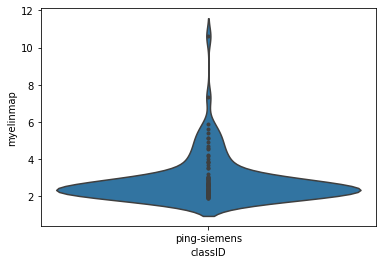

In [112]:
sns.violinplot(x='classID',y='myelinmap',data=cortical_reference_pre.loc[cortical_reference_pre['structureID'] == 'R_V3_ROI'],scale='count',inner='points')

In [49]:
#### tractometry reference generation
print("creating tract profile references")

# create data structures
# tractmeasures data
if os.path.isfile(data_dir+'/tractmeasures-reference_preclean.csv'):
    track_reference_pre = pd.read_csv(data_dir+'/tractmeasures-reference_preclean.csv')
else:
    track_reference_pre =  collectData('neuro/tractmeasures','macro_micro','dti','output_FiberStats.csv',subjects_data,colors,data_dir+'/tractmeasures-reference_preclean.csv')
    track_reference_pre = track_reference_pre.drop_duplicates()
    track_reference_pre = track_reference_pre.loc[~track_reference_pre['fa'].isna()]
    track_reference_pre.to_csv(data_dir+'/tractmeasures-reference_preclean.csv',index=False)
    
# track_measures = [ f for f in track_reference_pre.keys() if f not in ['subjectID','structureID','nodeID','classID','sex'] ]
track_structural_measures = ['length','volume','count']
track_diffusion_measures = ['ad','fa','md','rd']

# generate tractmeasures reference and outliers
# track_structural_distances, track_structural_outliers, track_structural_reference_dataframe, track_structural_reference_json = outlierDetection(track_reference_pre,track_reference_pre.structureID.unique(),'nodeID',track_structural_measures,95,'euclidean',True,False,"",data_dir+'/references','tractmeasures_structural_reference_ping_siemens')
track_diffusion_distances, track_diffusion_outliers, track_diffusion_reference_dataframe, track_diffusion_reference_json = outlierDetection(track_reference_pre,track_reference_pre.structureID.unique(),'nodeID',track_diffusion_measures,95,'euclidean',True,True,50,data_dir+'/references','tractmeasures_diffusion_reference_ping_siemens')

print("creating tract profile references complete")

creating tract profile references
anterioFrontalCC
forcepsMajor
forcepsMinor
leftAnterioFrontoCerebellar
leftArc
leftAslant
leftCST
leftContraAnterioFrontoCerebellar
leftContraMotorCerebellar
leftIFOF
leftILF
leftMDLFang
leftMDLFspl
leftMotorCerebellar
leftOccipitoCerebellar
leftParietoCerebellar
leftSLF1And2
leftSLF3
leftTPC
leftThalamicoCerebellar
leftUncinate
leftVOF
leftbaum
leftcingulum
leftfrontoThalamic
leftmeyer
leftmotorThalamic
leftpArc
leftparietoThalamic
leftspinoThalamic
lefttemporoThalamic
middleFrontalCC
parietalCC
rightAnterioFrontoCerebellar
rightArc
rightAslant
rightCST
rightContraAnterioFrontoCerebellar
rightContraMotorCerebellar
rightIFOF
rightILF
rightMDLFang
rightMDLFspl
rightMotorCerebellar
rightOccipitoCerebellar
rightParietoCerebellar
rightSLF1And2
rightSLF3
rightTPC
rightThalamicoCerebellar
rightUncinate
rightVOF
rightbaum
rightcingulum
rightfrontoThalamic
rightmeyer
rightmotorThalamic
rightpArc
rightparietoThalamic
rightspinoThalamic
righttemporoThalamic
crea

In [41]:
track_reference_pre.keys()

Index(['subjectID', 'structureID', 'nodeID', 'ad', 'fa', 'md', 'rd', 'count',
       'length', 'volume', 'sex', 'classID'],
      dtype='object')

In [39]:
gb_frame.groupby('nodeID').quantile(q=.85)

,fa
nodeID,
1,0.296859
2,0.314166
3,0.329603
4,0.342963
5,0.356301
...,...
196,0.345235
197,0.331564
198,0.316183


In [ ]:
           if profile:
                gb_frame = ref_data.loc[ref_data['structureID'] == st][['nodeID',meas]].dropna().groupby('nodeID')[meas]
            else:
                gb_frame = ref_data.loc[ref_data['structureID'] == st][[meas]].dropna()[meas]
            
            data_tmp = []
            if resample_points:
#                 for subs in gb_frame.structureID.unique():
#                     data_tmp = np.append(data_tmp,resample(gb_frame.loc[gb_frame['subjectID'] == subs].values.tolist(),resample_points).tolist())
                
                mean_tmp = resample(gb_frame.mean().values.tolist(),resample_points).tolist()


In [127]:
track_reference_json

[{'structurename': 'anterioFrontalCC',
  'source': 'ping-siemens',
  'ad': {'mean': [1.0117264253778158,
    1.0431333090474921,
    1.0833901298229152,
    1.1143198258261795,
    1.1374781938453988,
    1.1587520387638621,
    1.1815366852104519,
    1.2084311649769848,
    1.2397139069416865,
    1.276645291086598,
    1.3200152949670787,
    1.3707788100373441,
    1.4284716806882845,
    1.492928251172733,
    1.5620585800580709,
    1.6345313875432141,
    1.7071440286297028,
    1.776002311446432,
    1.836109881071325,
    1.8848568185840944,
    1.9201379106029455,
    1.9428770415691206,
    1.9548717939913247,
    1.9600245282956197,
    1.9613822187268601,
    1.9617743352627621,
    1.962053598239721,
    1.9617691925114145,
    1.9590147452999855,
    1.951220418504349,
    1.9335826540480476,
    1.9030165412725544,
    1.8588207151491503,
    1.8019281312646767,
    1.7347974622287097,
    1.6615837757168408,
    1.5858931192373646,
    1.5111984727075076,
    1.4401074

In [4]:
data_dir = './data'
with open(data_dir+'/cortical_reference_ping_siemens.json','r') as cortical:
    cortical_reference_json = json.load(cortical)

In [5]:
with open(data_dir+'/subcortical_reference_ping_siemens.json','r') as subcortical:
    subcortical_reference_json = json.load(subcortical)

In [12]:
measures = list(subcortical_reference_json[0].keys())[2::]
summ_measures = ['mean','min','max','sd']

for i in range(len(subcortical_reference_json)):
    for j in measures:
        for k in summ_measures:
            subcortical_reference_json[i][j][k] = round(subcortical_reference_json[i][j][k],3)
            
subcortical_reference_json

[{'structurename': '3rd-Ventricle',
  'source': 'ping-siemens',
  'ad': {'mean': 2.454, 'min': 1.952, 'max': 2.998, 'sd': 0.232},
  'fa': {'mean': 0.175, 'min': 0.144, 'max': 0.22, 'sd': 0.015},
  'md': {'mean': 2.092, 'min': 1.564, 'max': 2.52, 'sd': 0.208},
  'rd': {'mean': 1.912, 'min': 1.417, 'max': 2.318, 'sd': 0.197},
  'gray_matter_volume_mm^3': {'mean': 700.37,
   'min': 374.0,
   'max': 1081.0,
   'sd': 167.068}},
 {'structurename': '4th-Ventricle',
  'source': 'ping-siemens',
  'ad': {'mean': 2.871, 'min': 2.646, 'max': 2.974, 'sd': 0.087},
  'fa': {'mean': 0.18, 'min': 0.146, 'max': 0.216, 'sd': 0.018},
  'md': {'mean': 2.417, 'min': 2.243, 'max': 2.51, 'sd': 0.082},
  'rd': {'mean': 2.19, 'min': 2.022, 'max': 2.316, 'sd': 0.096},
  'gray_matter_volume_mm^3': {'mean': 1065.867,
   'min': 757.0,
   'max': 1521.0,
   'sd': 250.682}},
 {'structurename': '5th-Ventricle',
  'source': 'ping-siemens',
  'ad': {'mean': 2.451, 'min': 2.451, 'max': 2.451, 'sd': nan},
  'fa': {'mean': 

In [13]:
graymatter_reference_json = cortical_reference_json + subcortical_reference_json

with open(data_dir+'/graymatter_reference_json_ping_siemens.json','w') as out_f:
    json.dump(graymatter_reference_json,out_f)